# Importing data

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
label_encoder = preprocessing.LabelEncoder()

account_df = pd.read_csv('data/account.csv',sep=';')
card_df = pd.read_csv('data/card_dev.csv', sep=';')
client_df = pd.read_csv('data/client.csv',sep=';')
disp_df = pd.read_csv('data/disp.csv',sep=';')
district_df = pd.read_csv('data/district.csv',sep=';')
loan_df = pd.read_csv('data/loan_dev.csv', sep=';')
trans_df = pd.read_csv("data/trans_dev.csv",sep=";", low_memory=False)

# Account Stats

#### Data cleaning, transformation and data quality changes

In [2]:
print(account_df)
account_df.rename(columns={'frequency':'account_frequency'}, inplace=True)
account_df.rename(columns={'date':'account_date'}, inplace=True)

account_df.loc[account_df['account_frequency'] == 'monthly issuance', 'account_frequency'] = 'monthly'
account_df.loc[account_df['account_frequency'] == 'weekly issuance', 'account_frequency'] = 'weekly'
account_df.loc[account_df['account_frequency'] == 'issuance after transaction', 'account_frequency'] = 'after-transaction'


      account_id  district_id         frequency    date
0            576           55  monthly issuance  930101
1           3818           74  monthly issuance  930101
2            704           55  monthly issuance  930101
3           2378           16  monthly issuance  930101
4           2632           24  monthly issuance  930102
...          ...          ...               ...     ...
4495         124           55  monthly issuance  971228
4496        3958           59  monthly issuance  971228
4497         777           30  monthly issuance  971228
4498        1573           63  monthly issuance  971229
4499        3276            1  monthly issuance  971229

[4500 rows x 4 columns]


In [3]:

#Frequency from text data to numerical
account_df['account_frequency']= label_encoder.fit_transform(account_df['account_frequency'])



account_df['account_date'] = pd.to_datetime(account_df['account_date'], format='%y%m%d')

acount_date_year = []
for i in account_df.index:
    acount_date_year.append(account_df['account_date'][i].year)

account_df['account_year'] = acount_date_year
#account_df.drop(columns=account_df.columns[0], axis=1, inplace=True)
print(account_df.head())
account_df.to_csv('refined/account.csv',sep=';',index=False)

   account_id  district_id  account_frequency account_date  account_year
0         576           55                  1   1993-01-01          1993
1        3818           74                  1   1993-01-01          1993
2         704           55                  1   1993-01-01          1993
3        2378           16                  1   1993-01-01          1993
4        2632           24                  1   1993-01-02          1993


# Client Processing


#### Data cleaning, transformation and data quality changes

In [4]:
client_df.rename(columns={'district_id':'client_district_id'}, inplace=True)
client_df.rename(columns={'birth_number':'client_birth_number'}, inplace=True)


age = []
gender = []
birth = []
get_birth_date = lambda x : pd.to_datetime('19'+str(x)[0:2] + str(x)[2:4] + str(x)[4:6])
for x in client_df['client_birth_number']:
    month = int(str(x)[2:4])
    if month > 12:
        gender.append('F')
        x -= 5000
    else:
        gender.append('M')
    
    birth_date = get_birth_date(x)
    birth.append(birth_date)
    age.append((datetime.now() - birth_date).days // 365)

client_df['client_birth_number'] = birth

birth_year = []
for i in client_df.index:
    birth_year.append(client_df['client_birth_number'][i].year)

client_df['birth_year'] = birth_year
    
print(client_df.head())

client_df['client_age'] = age
client_df['client_gender'] = gender


client_df['client_gender']= label_encoder.fit_transform(client_df['client_gender'])

client_df.to_csv('refined/client.csv',sep=';',index=False)

   client_id client_birth_number  client_district_id  birth_year
0          1          1970-12-13                  18        1970
1          2          1945-02-04                   1        1945
2          3          1940-10-09                   1        1940
3          4          1956-12-01                   5        1956
4          5          1960-07-03                   5        1960


# Disposition Processing

#### Data cleaning, transformation and data quality changes

In [5]:
# disp_df = disp_df.loc[disp_df.type == "OWNER"]
# disp_df.drop(columns=['type'], inplace=True)
# disp_df.rename(columns={'type':'disp_type'}, inplace=True)
print(disp_df.isnull().sum())
disp_df.to_csv('refined/disposition.csv',sep=';',index=False)

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64


# Transaction Processing

In [6]:
trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d')

trans_date_year = []
trans_date_month = []
trans_date_day = []
for i in trans_df.index:
    trans_date_year.append(trans_df['trans_date'][i].year)
    trans_date_month.append(trans_df['trans_date'][i].month)
    trans_date_day.append(trans_df['trans_date'][i].day)

trans_df['trans_year'] = trans_date_year
trans_df['trans_month'] = trans_date_month
trans_df['trans_day'] = trans_date_day

#as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
trans_df.drop(['trans_bank', 'trans_account', 'trans_k_symbol'], axis=1, inplace=True)

trans_df.loc[trans_df["trans_operation"].isnull(),"trans_operation"] = "other_type"
#se for withdrawal, o ammount é negativo
trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1
trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_amount"] *= -1

print(trans_df.head())


trans_df.to_csv('refined/transaction.csv',sep=';',index=False)

   trans_id  account_id trans_date trans_type               trans_operation  \
0   1548749        5270 1993-01-13     credit                credit in cash   
1   1548750        5270 1993-01-14     credit  collection from another bank   
2   3393738       11265 1993-01-14     credit                credit in cash   
3   3122924       10364 1993-01-17     credit                credit in cash   
4   1121963        3834 1993-01-19     credit                credit in cash   

   trans_amount  trans_balance  trans_year  trans_month  trans_day  
0         800.0          800.0        1993            1         13  
1       44749.0        45549.0        1993            1         14  
2        1000.0         1000.0        1993            1         14  
3        1100.0         1100.0        1993            1         17  
4         700.0          700.0        1993            1         19  


#### Data cleaning, transformation and data quality changes to check if we decide to use k_symbol using some techniques for null values

In [7]:
# trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
# trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
# trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
# trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
# trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
# trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
# trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
# trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

# trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d')

# trans_date_year = []
# for i in trans_df.index:
#     trans_date_year.append(trans_df['trans_date'][i].year)

# trans_df['trans_year'] = trans_date_year
# print(trans_df.head())

# #as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
# #trans_df.drop(['trans_bank', 'trans_account', ], axis=1)

# #withdrawal in cash para withdrawal
# trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_type"] = "withdrawal" 
# trans_df.loc[trans_df["trans_operation"].isnull(),"trans_operation"] = "other_type"
# #se for withdrawal, o ammount é negativo
# trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1



# trans_df.to_csv('refined/transaction.csv',sep=';',index=False)


# Loan Processing

#### Data cleaning, transformation and data quality changes

In [8]:

loan_df.rename(columns={'date':'loan_date'}, inplace=True)
loan_df.rename(columns={'amount':'loan_amount'}, inplace=True)
loan_df.rename(columns={'duration':'loan_duration'}, inplace=True)
loan_df.rename(columns={'payments':'loan_payments'}, inplace=True)
loan_df.rename(columns={'status':'loan_status'}, inplace=True)
loan_df.loc[loan_df["loan_status"]== -1,"loan_status"] *= 0

loan_df['loan_date'] = pd.to_datetime(loan_df['loan_date'], format='%y%m%d')

loan_date_year = []
for i in loan_df.index:
    loan_date_year.append(loan_df['loan_date'][i].year)
loan_df['loan_year'] = loan_date_year

loan_df.to_csv('refined/loan.csv',sep=';',index=False)

# Credit Card Processing

#### Data cleaning, transformation and data quality changes

In [9]:
card_df.rename(columns={'type' : 'card_type'}, inplace=True)
card_df.rename(columns={'issued' : 'card_issued'}, inplace=True)


card_df['card_issued'] = pd.to_datetime(card_df['card_issued'], format='%y%m%d')

issued_year = []
for i in card_df.index:
    issued_year.append(card_df['card_issued'][i].year)
card_df['car_issued_year'] = issued_year


card_df.to_csv('refined/card.csv',sep=';',index=False)

# District (demograph) Processing

#### Data cleaning, transformation and data quality changes

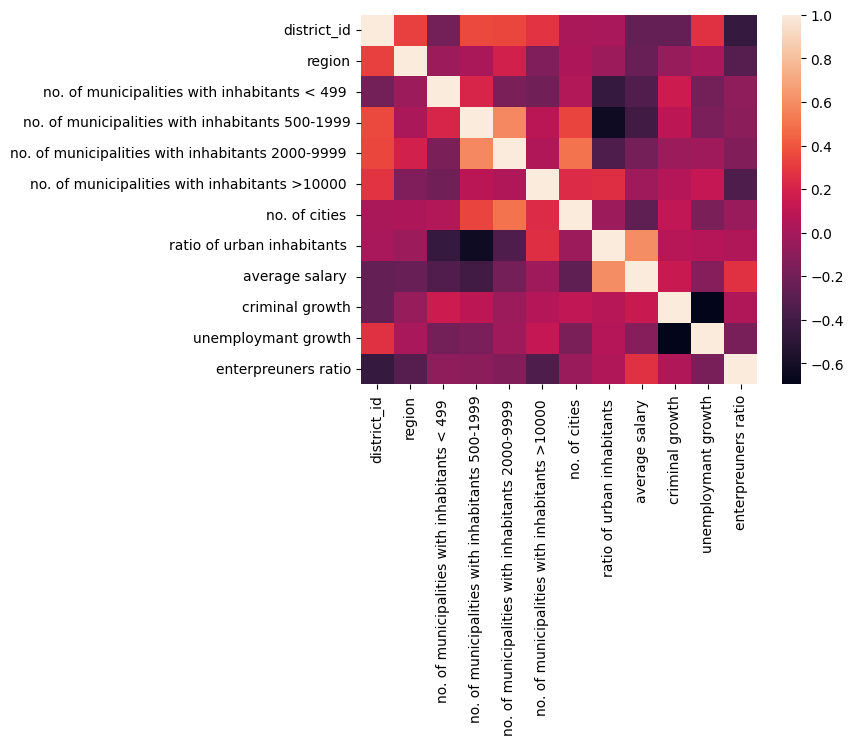

In [10]:
district_df.rename(columns={'code ' : 'district_id'}, inplace=True)
district_df["unemploymant rate '95 "] = pd.to_numeric(district_df["unemploymant rate '95 "], errors='coerce')
#filling NA values with mean
district_df["unemploymant rate '95 "].fillna(district_df["unemploymant rate '95 "].mean(), inplace=True)

district_df["no. of commited crimes '95 "] = pd.to_numeric(district_df["no. of commited crimes '95 "], errors='coerce')
#filling NA values with mean
district_df["no. of commited crimes '95 "].fillna(district_df["no. of commited crimes '95 "].mean(), inplace=True)

#growths
district_df["criminal growth"] = (district_df["no. of commited crimes '96 "] - district_df["no. of commited crimes '95 "]) / district_df["no. of inhabitants"]
district_df['unemploymant growth'] = district_df["unemploymant rate '96 "] - district_df["unemploymant rate '95 "]

#simplifying ratios lmao
district_df['enterpreuners ratio'] = district_df['no. of enterpreneurs per 1000 inhabitants '] / 1000
district_df['ratio of urban inhabitants '] = district_df['ratio of urban inhabitants '] / 100

#Region attribute to numerical
district_df['region']= label_encoder.fit_transform(district_df['region'])

district_df.drop(columns=['name ', 'no. of enterpreneurs per 1000 inhabitants ', 'no. of inhabitants',
        "unemploymant rate '96 ", "no. of commited crimes '96 ",
        "unemploymant rate '95 ", "no. of commited crimes '95 "], inplace=True)

corr = district_df.corr()
sns.heatmap(corr);
district_df.to_csv('refined/district.csv',sep=';',index=False)

# Merging data

#### Data cleaning, transformation and data quality changes

In [11]:
refined_df = loan_df.merge(disp_df, on='account_id')
refined_df = refined_df.merge(client_df, on='client_id')
refined_df = refined_df.merge(account_df, on='account_id')
refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
refined_df = refined_df.merge(trans_df, on='account_id')
#refined_df = refined_df.merge(card_df, on='disp_id')
get_age = lambda initial_date, cur_date: cur_date.year - initial_date.year - ((cur_date.month, cur_date.day) < (initial_date.month, initial_date.day))
get_account_age = lambda initial_date,cur_date : (cur_date.year - initial_date.year) * 12 + cur_date.month - initial_date.month
refined_df['age on loan'] = refined_df.apply(lambda row: get_age(row['client_birth_number'], row['loan_date']), axis=1)
refined_df['account age at loan'] = refined_df.apply(lambda row: get_account_age(row['account_date'], row['loan_date']), axis=1)
print(refined_df.head())
new_refined =refined_df.drop(["trans_operation",
    'account_id', 'disp_id', 'client_district_id', 'district_id_x', 'district_id_y', 'trans_id', 'client_birth_number', 'account_date',
     'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
    'no. of municipalities with inhabitants >10000 ', 'no. of cities '
], axis=1)

new_refined.sort_values(by=["loan_date","client_id"], inplace=True)
new_refined.to_csv('refined/final_data.csv',sep=';',index=False)
print(new_refined)



   loan_id  account_id  loan_date  loan_amount  loan_duration  loan_payments  \
0     5314        1787 1993-07-05        96396             12           8033   
1     5314        1787 1993-07-05        96396             12           8033   
2     5314        1787 1993-07-05        96396             12           8033   
3     5314        1787 1993-07-05        96396             12           8033   
4     5316        1801 1993-07-11       165960             36           4610   

   loan_status  loan_year  disp_id  client_id  ... trans_date trans_type  \
0            0       1993     2166       2166  ... 1993-03-22     credit   
1            0       1993     2166       2166  ... 1993-04-21     credit   
2            0       1993     2166       2166  ... 1993-05-21     credit   
3            0       1993     2166       2166  ... 1993-06-20     credit   
4            1       1993     2181       2181  ... 1993-02-13     credit   

   trans_operation  trans_amount  trans_balance  trans_year  t

In [12]:
new_refined

,loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_year,client_id,type,birth_year,...,enterpreuners ratio,trans_date,trans_type,trans_amount,trans_balance,trans_year,trans_month,trans_day,age on loan,account age at loan
0,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-03-22,credit,1100.0,1100.0,1993,3,22,45,4
1,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-04-21,credit,9900.0,11000.0,1993,4,21,45,4
2,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-05-21,credit,5800.0,16800.0,1993,5,21,45,4
3,5314,1993-07-05,96396,12,8033,0,1993,2166,OWNER,1947,...,0.100,1993-06-20,credit,3300.0,20100.0,1993,6,20,45,4
4,5316,1993-07-11,165960,36,4610,1,1993,2181,OWNER,1968,...,0.117,1993-02-13,credit,700.0,700.0,1993,2,13,24,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-06,withdrawal,-129.0,39765.5,1996,12,6,34,14
22440,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-07,withdrawal,-10400.0,29365.5,1996,12,7,34,14
22441,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-07,withdrawal,-330.0,29035.5,1996,12,7,34,14
22442,7308,1996-12-27,129408,24,5392,1,1996,13971,OWNER,1962,...,0.109,1996-12-08,withdrawal,-56.0,28979.5,1996,12,8,34,14


In [13]:
import data_understanding_utils as du
du.info_data(new_refined,"isnull","")

Number of null values: 
 loan_id                        0
loan_date                      0
loan_amount                    0
loan_duration                  0
loan_payments                  0
loan_status                    0
loan_year                      0
client_id                      0
type                           0
birth_year                     0
client_age                     0
client_gender                  0
account_frequency              0
account_year                   0
region                         0
ratio of urban inhabitants     0
average salary                 0
criminal growth                0
unemploymant growth            0
enterpreuners ratio            0
trans_date                     0
trans_type                     0
trans_amount                   0
trans_balance                  0
trans_year                     0
trans_month                    0
trans_day                      0
age on loan                    0
account age at loan            0
dtype: int64



#### Feature engineering merge data

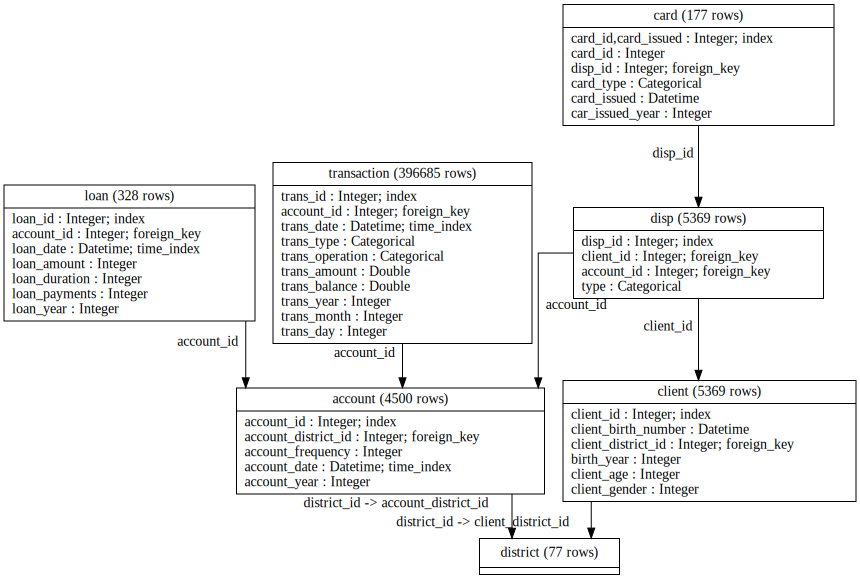

In [14]:
import featuretools as ft

# refined_df = pd.get_dummies(refined_df, columns=[""])

# corr = refined_df.corr( method='pearson')
# sns.heatmap(corr);
# refined_df = loan_df.merge(disp_df, on='account_id')
# refined_df = refined_df.merge(client_df, on='client_id')
# refined_df = refined_df.merge(account_df, on='account_id')
# refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
# refined_df = refined_df.merge(trans_df, on='account_id')


# refined_df_ft = refined_df_ft.merge(account_df, on='account_id')
# refined_df_ft = refined_df_ft.merge(district_df, left_on='client_district_id', right_on='district_id')
# refined_df_ft = refined_df_ft.merge(trans_df, on='account_id')
# print(refined_df_ft.head())
# #get merged data using featuretools
account_df.rename(columns={'district_id' : 'account_district_id'}, inplace=True)


# print(account_df.head())
# print(account_df.shape)
# print(account_df.isnull().sum())
# print(district_df.isnull().count())

# print(trans_df.isnull().count())
# print(loan_df.isnull().count())
# print(client_df.isnull().count())
# print(disp_df.isnull().count())


client = disp_df.merge(client_df, on='client_id')

#disp = disp_df.drop("disp_id", axis=1)

loan_df_aux = loan_df.drop("loan_status", axis=1, inplace=False)

ft_dataframes = {'loan': (loan_df_aux, "loan_id","loan_date") ,'client': (client_df, "client_id"), 
                 'district': (district_df,"district_id"), "account": (account_df, "account_id","account_date"),
    "transaction": (trans_df,"trans_id","trans_date"),"disp":(disp_df,"disp_id"),"card":(card_df,"card_id,card_issued")}

relationships = [
              ("account","account_id","disp","account_id" ),("client","client_id","disp","client_id")  , ("account","account_id","loan","account_id"), 
              ("district","district_id","client","client_district_id"), ("district","district_id","account","account_district_id"),
                 ("account","account_id","transaction","account_id"), ("disp","disp_id","card","disp_id")]



features_entityset_md_2 = ft.EntitySet('features_entity', ft_dataframes, relationships)
features_entityset_md_2.plot()


In [15]:
feature_matrix_loans_md_2, features_loans_defs = ft.dfs(
    dataframes=ft_dataframes,
    relationships=relationships,
    target_dataframe_name="loan",
    max_depth = 7, verbose = 1, n_jobs = 1
    
)
import numpy as np
import AutoClean as ac
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#feature_matrix_loans_md_2.head()

#encode categorical data gives more features
feature_matrix_enc_md_2, features_enc_md_2 = ft.encode_features(feature_matrix_loans_md_2, features_loans_defs)
feature_matrix_enc_md_2, features_enc_md_2 = ft.selection.remove_low_information_features(feature_matrix_enc_md_2, features_enc_md_2 )
feature_matrix_enc_md_2, features_enc_md_2 = ft.selection.remove_highly_null_features(feature_matrix_enc_md_2, features_enc_md_2 , pct_null_threshold=0.0001)
feature_matrix_enc_md_2, features_enc_md_2 = ft.selection.remove_single_value_features(feature_matrix_enc_md_2, features_enc_md_2 )
ffeature_matrix_enc_md_2, features_enc_md_2 = ft.selection.remove_highly_correlated_features(feature_matrix_enc_md_2, features_enc_md_2,pct_corr_threshold=0.95)
#dropna(self, axis=0, how="any", thresh=None, subset=None, inplace=False)
#ac.AutoClean(feature_matrix_enc_md_2)
#feature_matrix_loans_md_2, features_loans_defs =ft.remove_low_information_features(feature_matrix_loans_md_2, features_loans_defs)

normMinMaxScaler = MinMaxScaler()
normRobustScaler = RobustScaler()
normStandardScaler = StandardScaler()

print(feature_matrix_enc_md_2.shape)

#Applying the normalization techniques
ft_df_rs_md_2 =  pd.DataFrame(normRobustScaler.fit_transform( feature_matrix_enc_md_2),columns= feature_matrix_enc_md_2.columns)
ft_df_mms_md_2 = pd.DataFrame(normMinMaxScaler.fit_transform(feature_matrix_enc_md_2), columns=feature_matrix_enc_md_2.columns)
ft_df_ss_md_2 = pd.DataFrame(normStandardScaler.fit_transform(feature_matrix_enc_md_2), columns=feature_matrix_enc_md_2.columns) # for some models others not
ft_df_rs_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
ft_df_ss_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
ft_df_mms_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
feature_matrix_enc_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)

# ft_df_rs_md_2.insert(1, "loan_status", save_status)
# ft_df_ss_md_2.insert(1, "loan_status", save_status)
# ft_df_mms_md_2.insert(1, "loan_status", save_status)
# feature_matrix_enc_md_2.insert(1, "loan_status", save_status)

#ft.save_features(features_enc_md_2, 'refined/features_enc_md_2.csv')
feature_matrix_enc_md_2.to_csv('refined/feature_matrix_enc_md_2.csv',sep=';',index=False)
ft_df_rs_md_2.to_csv('refined/ft_df_rs_md_2.csv',sep=';',index=False)
ft_df_mms_md_2.to_csv('refined/ft_df_mms_md_2.csv',sep=';',index=False)
ft_df_ss_md_2.to_csv('refined/ft_df_ss_md_2.csv',sep=';',index=False)


Built 6938 features
Elapsed: 01:47 | Progress: 100%|██████████
(328, 2665)


In [16]:
feature_matrix_enc_md_2.head()



,loan_id,loan_amount,loan_duration,loan_payments,loan_year,account.account_frequency,account.account_year,account.COUNT(disp),account.NUM_UNIQUE(disp.type),account.COUNT(card),...,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) = 5,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) = 1,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) = 3,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) = 4,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) = 6,account.MODE(disp.client.district.MODE(client.disp.MODE(card.WEEKDAY(card_issued)))) is unknown,account.MODE(disp.client.district.MODE(client.disp.MODE(card.YEAR(card_issued)))) = 1996,account.MODE(disp.client.district.MODE(client.disp.MODE(card.YEAR(card_issued)))) = 1995,account.MODE(disp.client.district.MODE(client.disp.MODE(card.YEAR(card_issued)))) = 1994,account.MODE(disp.client.district.MODE(client.disp.MODE(card.YEAR(card_issued)))) is unknown
loan_id,,,,,,,,,,,,,,,,,,,,,
5314,5314,96396,12,8033,1993,2,1993,1,1,0,...,False,False,False,False,False,False,False,True,False,False
5316,5316,165960,36,4610,1993,1,1993,1,1,0,...,False,True,False,False,False,False,True,False,False,False
6863,6863,127080,60,2118,1993,1,1993,1,1,0,...,False,False,False,True,False,False,False,False,True,False
5325,5325,105804,36,2939,1993,1,1993,1,1,0,...,False,False,False,False,False,False,False,True,False,False
7240,7240,274740,60,4579,1993,2,1993,1,1,0,...,False,False,False,True,False,False,False,True,False,False


In [17]:
from tsfresh import extract_features,select_features
from tsfresh.utilities.dataframe_functions import impute
#ft_df_mms_md_2.shape
# ft_df_mms_md_2.head()
# print(save_status.shape)
# print(ft_df_mms_md_2.shape)
#use tsfresh to extract features from time series data
print(ft_df_mms_md_2)
#save_status = ft_df_mms_md_2['loan_status']

# ft_df_mms_md_2 = ft_df_mms_md_2.drop(columns=['loan_status'])
# ft_df_rs_md_2 = ft_df_rs_md_2.drop(columns=['loan_status'])
# ft_df_ss_md_2 = ft_df_ss_md_2.drop(columns=['loan_status'])
# feature_matrix_enc_md_2 = feature_matrix_enc_md_2.drop(columns=['loan_status'])

impute(ft_df_ss_md_2)
impute(ft_df_mms_md_2)
impute(ft_df_rs_md_2)
#impute(feature_matrix_enc_md_2)

#ft_df_mms_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
ft_df_ss_md_2 = select_features(ft_df_ss_md_2, loan_df["loan_status"],ml_task='classification')
ft_df_mms_md_2 = select_features(ft_df_mms_md_2, loan_df["loan_status"],ml_task='classification' )
ft_df_rs_md_2 = select_features(ft_df_rs_md_2, loan_df["loan_status"] ,ml_task='classification')

#feature_matrix_enc_md_2 = select_features(feature_matrix_enc_md_2, loan_df["loan_status"],ml_task='classification' )

# ft_df_rs_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
# ft_df_ss_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
# ft_df_mms_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)
# feature_matrix_enc_md_2.insert(0, "loan_id", feature_matrix_enc_md_2.index)

ft_df_rs_md_2.insert(1, "loan_status", loan_df["loan_status"])
ft_df_ss_md_2.insert(1, "loan_status", loan_df["loan_status"])
ft_df_mms_md_2.insert(1, "loan_status", loan_df["loan_status"])
feature_matrix_enc_md_2.insert(1, "loan_status", loan_df["loan_status"])


feature_matrix_enc_md_2.to_csv('refined/feature_matrix_enc_md_2.csv',sep=';',index=False)
ft_df_rs_md_2.to_csv('refined/ft_df_rs_md_2.csv',sep=';',index=False)
ft_df_mms_md_2.to_csv('refined/ft_df_mms_md_2.csv',sep=';',index=False)
ft_df_ss_md_2.to_csv('refined/ft_df_ss_md_2.csv',sep=';',index=False)
ft_df_rs_md_2.shape

     loan_id  loan_amount  loan_duration  loan_payments  loan_year  \
0       5314     0.171345           0.00       0.823266        0.0   
1       5316     0.301732           0.50       0.457951        0.0   
2       6863     0.228857           1.00       0.191996        0.0   
3       5325     0.188979           0.50       0.279616        0.0   
4       7240     0.505623           1.00       0.454642        0.0   
..       ...          ...            ...            ...        ...   
323     6818     0.282344           0.75       0.311953        1.0   
324     5625     0.407108           1.00       0.361153        1.0   
325     6805     0.075056           0.75       0.066062        1.0   
326     7233     0.207737           0.50       0.309285        1.0   
327     7308     0.233221           0.25       0.541409        1.0   

     account.account_frequency  account.account_year  account.COUNT(disp)  \
0                          1.0              0.000000                  0.0   
1    

(328, 32)

account_id                                                                                  0
loan_amount                                                                                 0
loan_duration                                                                               0
loan_payments                                                                               0
loan_year                                                                                   0
                                                                                           ..
account.SUM(disp.client.district.SUM(client.STD(disp.SUM(card.card_id))))                   0
account.SUM(disp.client.district.SUM(client.disp.NUM_UNIQUE(card.DAY(card_issued))))        0
account.SUM(disp.client.district.SUM(client.disp.NUM_UNIQUE(card.MONTH(card_issued))))      0
account.SUM(disp.client.district.SUM(client.disp.NUM_UNIQUE(card.WEEKDAY(card_issued))))    0
account.SUM(disp.client.district.SUM(client.disp.NUM_UNIQUE(

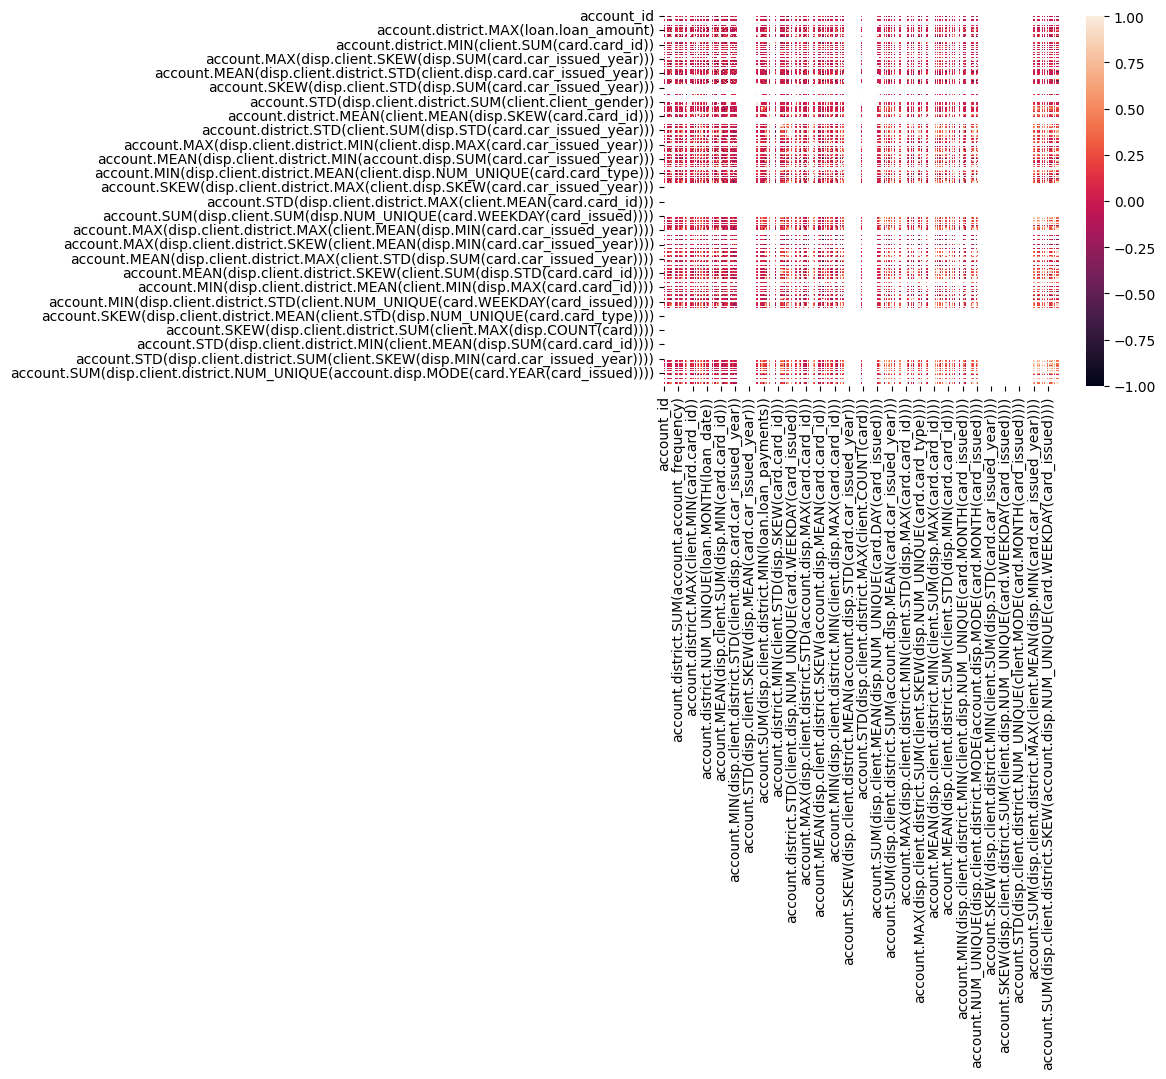

In [18]:

print(feature_matrix_loans_md_2.isnull().sum())
corr = feature_matrix_loans_md_2.corr()
sns.heatmap(corr);